# Predikcija plata u ekonomski razvijenim državama

**Autori:** Katarina Perović E2 131/2024, Milica Petrović E2 124/2024, Ana Radovanović E2 158/2024

**Predmet:** SIAP 

**1.Uvoz biblioteka**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys  
!{sys.executable} -m pip install seaborn

import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


[notice] A new release of pip is available: 23.3.1 -> 25.2
[notice] To update, run: C:\Users\Katarina\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## 2. Učitavanje i osnovna analiza podataka

In [2]:
df = pd.read_csv("Salary.csv")
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6684 entries, 0 to 6683
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Age                  6684 non-null   float64
 1   Gender               6684 non-null   object 
 2   Education Level      6684 non-null   int64  
 3   Job Title            6684 non-null   object 
 4   Years of Experience  6684 non-null   float64
 5   Salary               6684 non-null   float64
 6   Country              6684 non-null   object 
 7   Race                 6684 non-null   object 
 8   Senior               6684 non-null   int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 470.1+ KB


,Age,Education Level,Years of Experience,Salary,Senior
count,6684.000000,6684.000000,6684.000000,6684.000000,6684.000000
mean,33.610563,1.622382,8.077723,115307.175194,0.143477
std,7.595994,0.880474,6.029305,52806.810881,0.350585
min,21.000000,0.000000,0.000000,350.000000,0.000000
25%,28.000000,1.000000,3.000000,70000.000000,0.000000
50%,32.000000,1.000000,7.000000,115000.000000,0.000000
75%,38.000000,2.000000,12.000000,160000.000000,0.000000
max,62.000000,3.000000,34.000000,250000.000000,1.000000


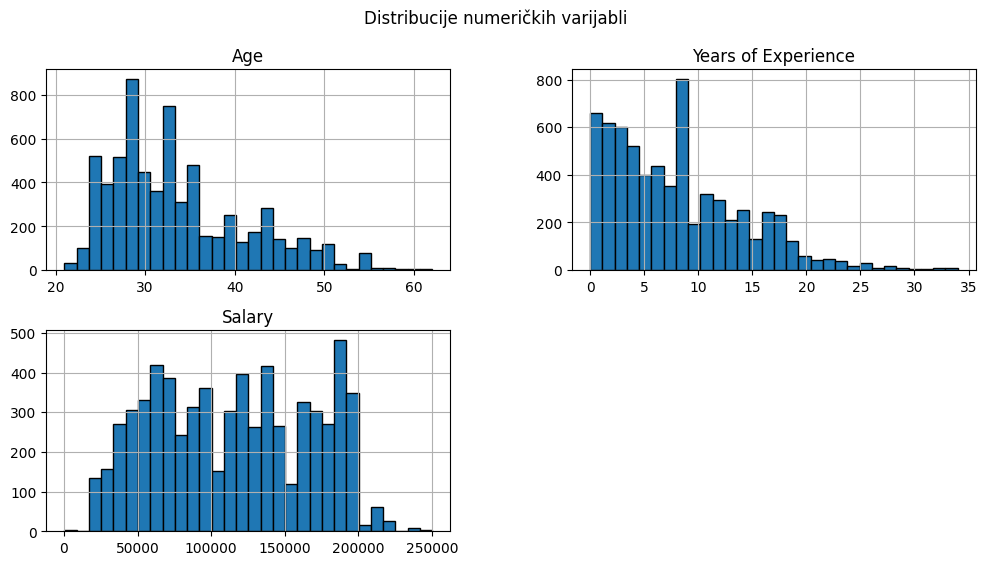

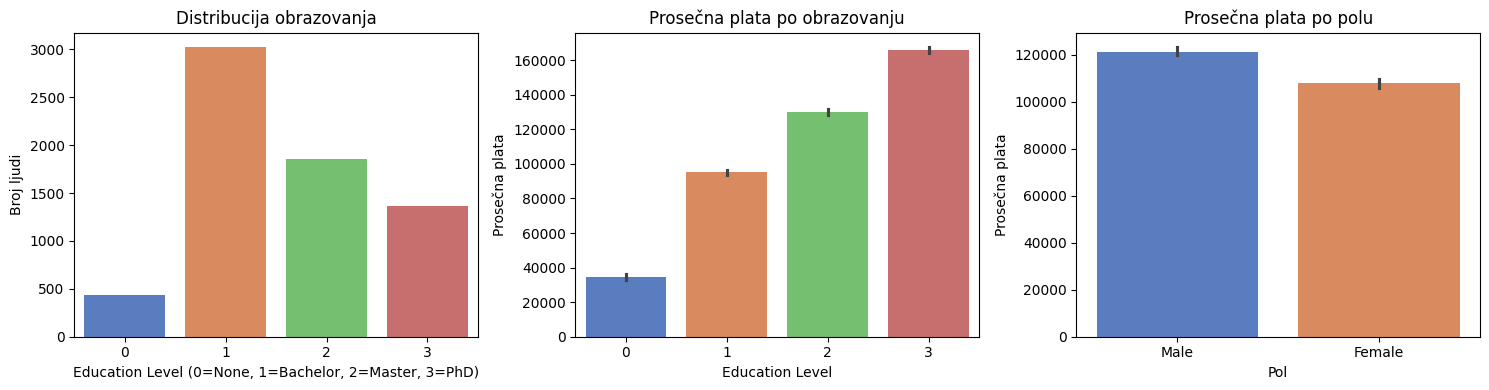

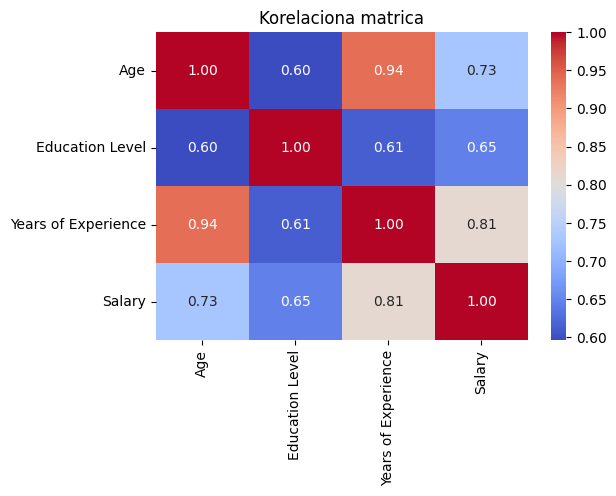

C:\Users\Katarina\AppData\Local\Temp\ipykernel_18228\1824177802.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Education Level", y="Salary", data=df, palette="muted")


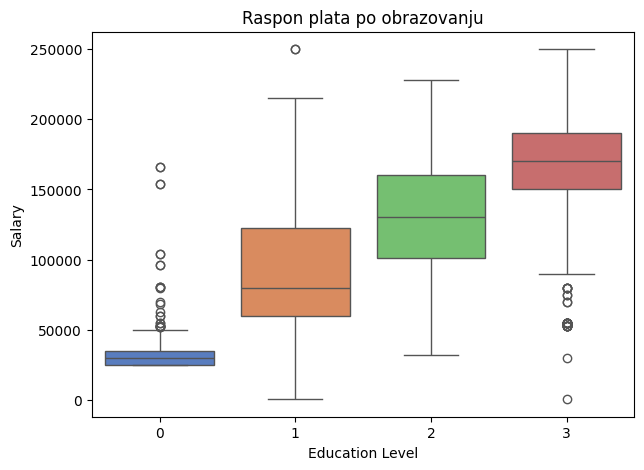

C:\Users\Katarina\AppData\Local\Temp\ipykernel_18228\1824177802.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Gender", y="Salary", data=df, palette="muted")


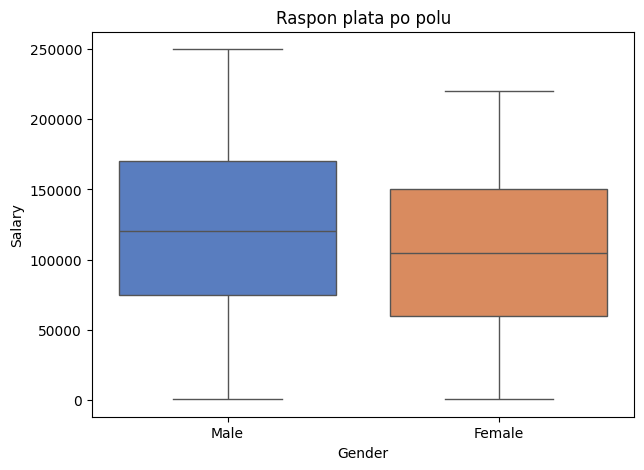

In [25]:
num_cols = ["Age", "Years of Experience", "Salary"]
df[num_cols].hist(bins=30, figsize=(12,6), edgecolor="black")
plt.suptitle("Distribucije numeričkih varijabli")
plt.show()


fig, axes = plt.subplots(1, 3, figsize=(15, 4)) 

sns.countplot(x="Education Level", data=df, hue="Education Level",
              legend=False, palette="muted", ax=axes[0])
axes[0].set_title("Distribucija obrazovanja")
axes[0].set_xlabel("Education Level (0=None, 1=Bachelor, 2=Master, 3=PhD)")
axes[0].set_ylabel("Broj ljudi")

sns.barplot(x="Education Level", y="Salary", data=df,
            estimator="mean", hue="Education Level",
            legend=False, palette="muted", ax=axes[1])
axes[1].set_title("Prosečna plata po obrazovanju")
axes[1].set_xlabel("Education Level")
axes[1].set_ylabel("Prosečna plata")

sns.barplot(x="Gender", y="Salary", data=df,
            estimator="mean", hue="Gender",
            legend=False, palette="muted", ax=axes[2])
axes[2].set_title("Prosečna plata po polu")
axes[2].set_xlabel("Pol")
axes[2].set_ylabel("Prosečna plata")

plt.tight_layout()
plt.show()


plt.figure(figsize=(6,4))
corr = df[["Age", "Education Level", "Years of Experience", "Salary"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Korelaciona matrica")
plt.show()

#srediti sutra jos ova dva dole

plt.figure(figsize=(7,5))
sns.boxplot(x="Education Level", y="Salary", data=df, palette="muted")
plt.title("Raspon plata po obrazovanju")
plt.show()

plt.figure(figsize=(7,5))
sns.boxplot(x="Gender", y="Salary", data=df, palette="muted")
plt.title("Raspon plata po polu")
plt.show()
